# Triplet Loss and Clustering


## Loading libraries

In [3]:
#export
from fastai.vision.all import *
import umap
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import torch.nn as nn
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

In [11]:
seed=42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

## Loading the Data

In [12]:
path = untar_data(URLs.CIFAR)/'train'

In [13]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2))

## UMAP of Images

<AxesSubplot:xlabel='x1', ylabel='x2'>

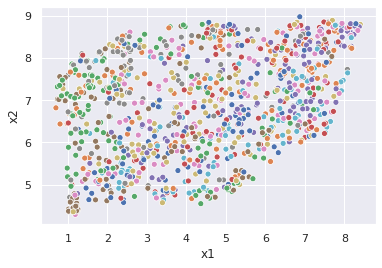

In [5]:
torch.cuda.empty_cache()

# Getting a batch of imgs and their labels
dls = data.dataloaders(path, bs=800)
imgs, y = dls.valid.one_batch()
vcb = dls.vocab
lbls = vcb[y]

# Using Umap to embed the imgs in 2d
um = umap.UMAP().fit_transform(imgs.flatten(1).cpu())
um = pd.DataFrame(data=um, columns=['x1', 'x2'])
um['lbl'], um['y'] = lbls, y.cpu()

sns.scatterplot(data=um, x='x1', y='x2', hue='lbl', legend=False)

# Embeding and Clustering Images

## Defining Custom Loss classes

In [36]:
#export
class TripletLoss(Module):
    def __init__(self, p='cos', margin=0.1):
        self.margin = margin
        self.p = p
    
    def forward(self, embs, y):
        embs = embs.flatten(1)
        d = -embs@embs.T if self.p=='cos' else torch.cdist(embs,embs,self.p)
        N = len(embs)
        with torch.no_grad():            
            # Getting indexes of the Positive and Negative sample of each Anchor
            dp, dn = d.clone(), d.clone()
            dp[y!=y[:,None]], dn[y==y[:,None]] = -np.inf, np.inf

            p = dp.argmax(1)        
            n = dn.argmin(1)
            
        return (self.margin + d[range(N),p] - d[range(N),n]).clamp(0).sum()/N
    
class MixedLoss(Module):
    def __init__(self,  p='cos', alpha=1, margin=0.1):
        self.alpha = alpha
        self.CEL = CrossEntropyLossFlat()
        self.TL = TripletLoss(p='cos', margin=margin)   

    def forward(self, out, y):
        CEL = self.CEL(out[0], y)
        TL = self.TL(out[1], y)
        return CEL + self.alpha*TL 
    
    
class SumLoss(Module):
    def __init__(self, loss1 , loss2= CrossEntropyLossFlat, alpha=1.0, n_views=2, **kwargs):
        self.alpha = alpha
        self.loss1 = loss1(**kwargs)
        self.loss2 = loss2()
        self.n_views = n_views
        self.cel =[]
        self.usl = []
    def forward(self, out, y):
        y_cel = y.repeat(self.n_views)
        CEL = self.loss2(out[0],y_cel)
        self.cel.append(CEL)
        USL = self.loss1(out[1],y)
        self.usl.append(USL)
        return CEL+self.alpha*USL
        
        
        
class CEL(Module):
    def forward(self, out, y):
        CEL = CrossEntropyLossFlat()(out[0], y)
        return CEL         
        
        

In [9]:
provaloss = SumLoss(TripletLoss, margin=0.2)


In [35]:
embs = (torch.rand(10,10), torch.randn(10,20))
y = torch.tensor([1,2,2,1,3,3,1,2,2,4])
TL = provaloss(embs,y)
y.repeat(2)
y

tensor([1, 2, 2, 1, 3, 3, 1, 2, 2, 4])

## Defining Custom Fastai/Pytorch module

In [35]:
#export
class AnomalyDetectionModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head
    
    def forward(self, x):
        embs = self.head[0:5](self.encoder(x))   
        scrs = self.head[5:](embs)
        embs = F.normalize(embs)
        return scrs, embs
    
def splitter(model:(AnomalyDetectionModel,nn.Sequential)):
    if isinstance(model,AnomalyDetectionModel):
        return [params(model.encoder), params(model.head)]
    else:
        return [params(model[0]),params(model[1])]

def tl_accuracy(out, y):
    return accuracy(out[0], y)

def rm_embs(self):
    self.learn.pred = self.pred[0]

class UniformizedSplitter():
    def __init__(self,items,lbls,unif_fn,valid_pct=0.2, n_lbls=8, n_el=8):
        self.lbls = lbls
        self.unif_fn = unif_fn
        self.splits= RandomSplitter(valid_pct=valid_pct,seed=42)(items)
        self.n_lbls = n_lbls
        self.n_el = n_el
    def __call__(self,items):
        splits = self.splits
        return [self.unif_fn(idxs, self.lbls[idxs] , n_lbl=self.n_lbls, n_el=self.n_el) for idxs in splits]
 


## Testing the model and the loss functions

In [31]:
torch.cuda.empty_cache()
dls = data.dataloaders(path, bs=100).cpu()

encoder = create_body(resnet18, cut=-2)
head = create_head(512*2, 10, lin_ftrs=[50])
model = AnomalyDetectionModel(encoder, head).eval()

imgs, y = dls.one_batch()

scrs, embs = model(imgs)

In [33]:
tl = TripletLoss(p=2, margin=0.1)
cel = CrossEntropyLossFlat()
cel(scrs, y), tl(embs, y)

(tensor(2.4367, grad_fn=<NllLossBackward>),
 tensor(1.1848, grad_fn=<DivBackward0>))

## Training

In [18]:
torch.cuda.empty_cache()
dls = data.dataloaders(path, bs=100)
path_mdls = Path('models')

ps = [2, 'cos']
alphas = [1]
for p in ps:
    for n, alpha in enumerate(alphas):
        encoder, head = create_body(resnet18, cut=-2), create_head(512*2, 50, 10)
        learn = Learner(dls, 
                        AnomalyDetectionModel(encoder, head), 
                        loss_func=MixedLoss(p=p, alpha=alpha), 
                        splitter=my_splitter, 
                        metrics=tl_accuracy)

        learn.fine_tune(12)
        learn.export(path_mdls/f'{p}{n}.pkl')
        
# learn = cnn_learner(dls, resnet18, metrics=accuracy)
# learn.fine_tune(12)
# learn.export(path_mdls/'m.pkl')

epoch,train_loss,valid_loss,tl_accuracy,time
0,1.377405,0.828158,0.812300,00:23


KeyboardInterrupt: 

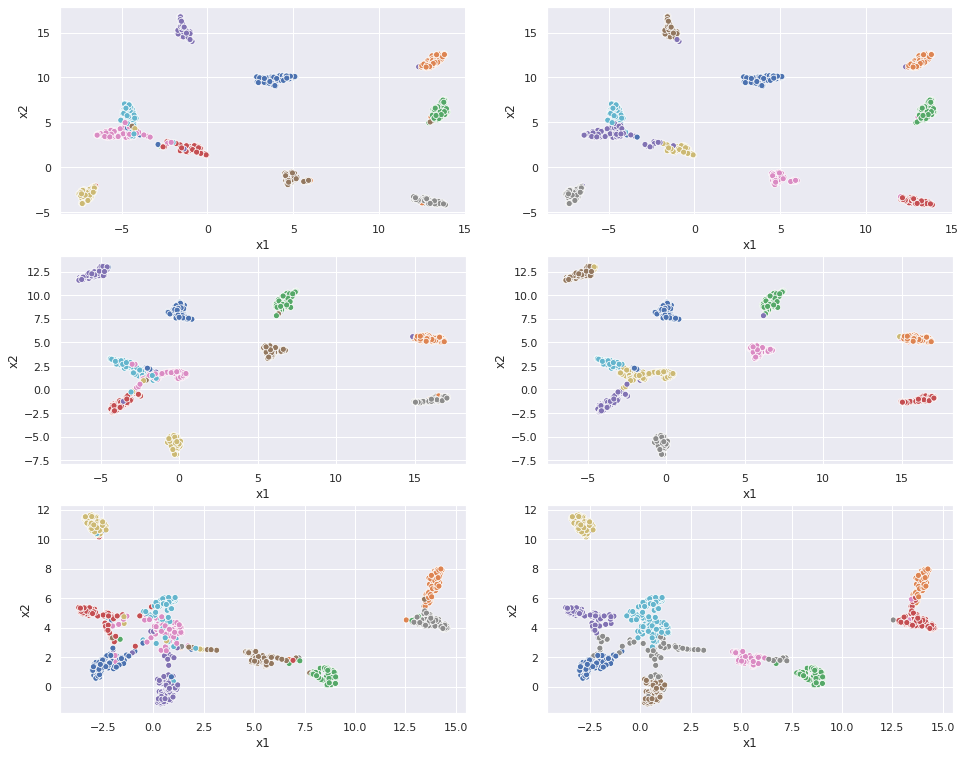

In [46]:
torch.cuda.empty_cache()
path_mdls = Path('models')
dls = data.dataloaders(path, bs=800).cpu()

imgs, y = dls.valid.one_batch()
vcb = dls.vocab
lbls = vcb[y]

seed=42
np.random.seed(seed)
alf = L(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))  # Used later to label the clusters with letters instead of numbers;
                                             # this solves a silly Seaborn bug

# mdl_names = ['alpha0','alpha1','alpha2', 'alpha3', 'm']
# mdl_names = ['cos0','cos1','cos2', 'cos3', 'm']
mdl_names = ['cos0', 'euc0', 'm']
n = len(mdl_names)
fig, axs = plt.subplots(n, 2, figsize=[16, 4.5*n])

s_scores = [] 
for name, ax in zip(mdl_names, axs):
    ## Calculating embedings
    learn = load_learner(path_mdls/(name + '.pkl'))
    m = learn.model.eval()
    with torch.no_grad():
        embs = m(imgs)
    
    ## Applying Umap dimensionality reduction
    um = umap.UMAP().fit_transform(embs.flatten(1).cpu())
    um = pd.DataFrame(data=um, columns=['x1', 'x2'])
    um['lbl'], um['y'] = lbls, y.cpu()
    
    ## Clustering    
#     preds = SpectralClustering(n_clusters=10, assign_labels="discretize", random_state=0).fit_predict(embs.flatten(1).cpu())
    preds = AgglomerativeClustering(10).fit_predict(embs.flatten(1).cpu())
    um["Cluster"] = alf[preds] 
    s_scores.append(silhouette_score(um[['x1', 'x2']], um['Cluster']))
    
    sns.scatterplot(data=um, x='x1', y='x2', hue='lbl', ax=ax[0], legend=False)
    sns.scatterplot(data=um, x='x1', y='x2', hue='Cluster', ax=ax[1], legend=False)
    
plt.show()    

In [11]:
cl_lbl = um.groupby(['Cluster','lbl']).size().to_frame(name='Count_Val')

In [3]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_triplet_loss.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 04_charades.ipynb.
Converted 05_ucf.ipynb.
Converted 06_distributed_inflated_NN.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_supconloss_module.ipynb.
Converted 09_create_embeddings.ipynb.
Converted 10_tools.ipynb.
Converted 11_pretrained_model_r2p1d50.ipynb.
Converted CALTECH101_MixedLoss.ipynb.
Converted CALTECH101_singleloss.ipynb.
Converted UCF101_SupCon.ipynb.
Converted UCF_Crimes_CEL.ipynb.
Converted UCF_Crimes_SupCon.ipynb.
Converted distributed_training.ipynb.


In [ ]:
# default_exp triplet_loss